# Working with raster data in Python

## Libraries and Settings

In [12]:
# Libraries
import os
import pprint
import requests
import numpy as np
import pandas as pd

import fiona
import geopandas as gpd

import rasterio #when you want to work with raster data
from rasterio import plot
import rasterio.mask

from shapely.geometry import Polygon

import matplotlib.patches as patches
from matplotlib import pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print(os.getcwd())

/workspaces/spatial_data_analysis/06_Python_Raster_Data


## Download example raster (.geotiff) from SwissTopo

Source: https://www.swisstopo.admin.ch/de/orthobilder-swissimage-10-cm

In [23]:
# Get example raster from swisstopo
url = "https://data.geo.admin.ch/ch.swisstopo.swissimage-dop10/swissimage-dop10_2022_2685-1243/swissimage-dop10_2022_2685-1243_0.1_2056.tif"
response = requests.get(url)

with open('swissimage.tif', 'wb') as f:
    f.write(response.content)

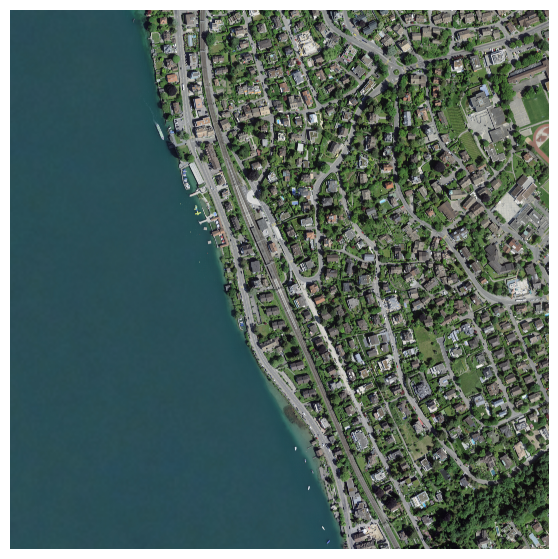

In [24]:
# Import raster
src = rasterio.open("swissimage.tif")

# Show raster
fig, ax = plt.subplots(figsize=(7,7))
rasterio.plot.show(src, ax=ax)

# Hide axes
ax.axis('off')

plt.show()


## Show histogram of RGB colors

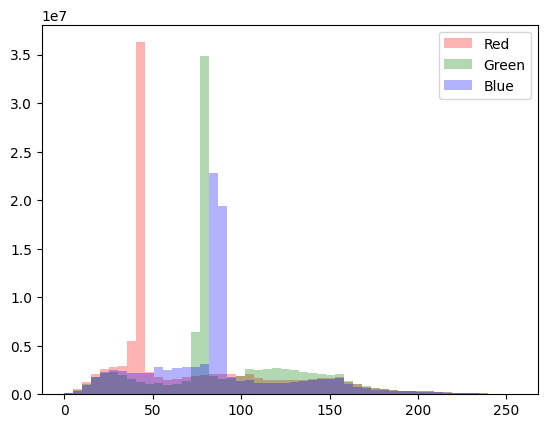

In [25]:
# Open raster
with rasterio.open('swissimage.tif') as src:
    
    red_band = src.read(1)
    green_band = src.read(2)
    blue_band = src.read(3)

# Flatten the arrays
red = red_band.flatten()
green = green_band.flatten()
blue = blue_band.flatten()

# Plot a histogram
plt.hist(red, bins=50, color='red', alpha=0.3, label='Red')
plt.hist(green, bins=50, color='green', alpha=0.3, label='Green')
plt.hist(blue, bins=50, color='blue', alpha=0.3, label='Blue')

plt.legend(loc='upper right')
plt.show()


## Masking a raster using a shapefile

### Create a shapefile

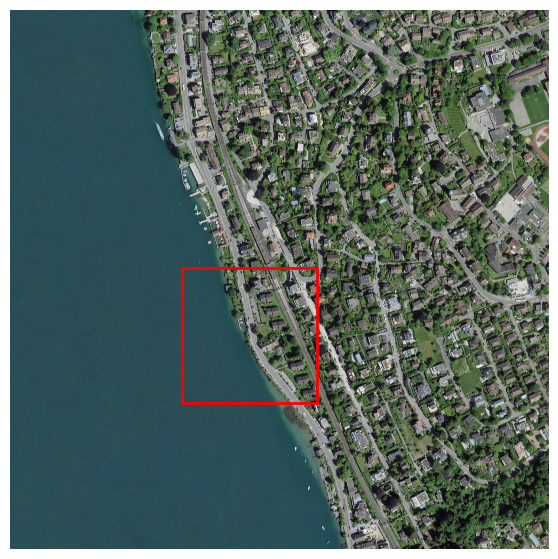

In [26]:
# Read raster
src = rasterio.open("swissimage.tif")

# Bottom left corner of square (LV95 coordinates)
x1, y1 = 2685319, 1243271

# Side lenght of square in meters
size = 250

# Create the other three corners
coordinates = [(x1, y1), (x1, y1 + size), (x1 + size, y1 + size), (x1 + size, y1)]

# Create a shapely polygon from the coordinates
polygon = Polygon(coordinates)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], geometry=[polygon])

# Save the GeoDataFrame as a shapefile
gdf.to_file("municipality_part.shp")

# Plot the shapefile over the raster
fig, ax = plt.subplots(figsize=(7,7))
rasterio.plot.show(src, ax=ax)
patch = patches.Polygon(coordinates, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(patch)
ax.axis('off')

plt.show()

### Masking the raster

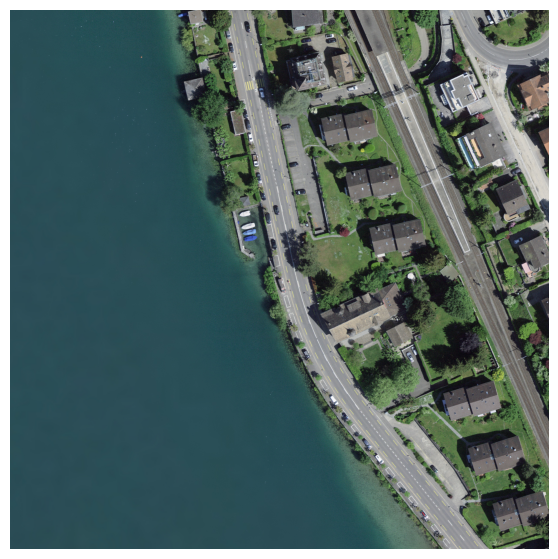

In [27]:
# Read shapefile
with fiona.open("municipality_part.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# Mask the raster with the shapefile
with rasterio.open("swissimage.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

# Plot the masked raster
fig, ax = plt.subplots(figsize=(7,7))
rasterio.plot.show(out_image, ax=ax)

# Hide the axes
ax.axis('off')

plt.show()

## Save masked raster as .geotiff

In [7]:
# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Write the masked image to a new GeoTIFF file
with rasterio.open("masked_swissimage.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Print metadata
print('Meta data:')
pprint.pprint(out_meta)

Meta data:
{'count': 3,
 'crs': CRS.from_wkt('PROJCS["CH1903+ / LV95",GEOGCS["CH1903+",DATUM["CH1903+",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6150"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4150"]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["latitude_of_center",46.9524055555556],PARAMETER["longitude_of_center",7.43958333333333],PARAMETER["azimuth",90],PARAMETER["rectified_grid_angle",90],PARAMETER["scale_factor",1],PARAMETER["false_easting",2600000],PARAMETER["false_northing",1200000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2056"]]'),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 2500,
 'nodata': None,
 'transform': Affine(0.1, 0.0, 2693300.0,
       0.0, -0.1, 1246817.0),
 'width': 2500}


### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [8]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2024-11-29 11:09:18
Python Version: 3.11.10
-----------------------------------
